In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

In [2]:
def solow(RSS1,RSS2,n):
    return ((RSS1 - RSS2)/3)/(RSS2/(n-4)) > scipy.stats.f.ppf(0.95,3,n-4) #Alpha = 0.05
def Ztest(X1, X2, sd1, sd2, n1, n2):
    pooledSE = np.sqrt(sd1**2/n1 + sd2**2/n2)
    z = (X1 - X2)/pooledSE
    return np.abs(z) > np.abs(scipy.stats.norm.ppf(0.025)) #Bilateral test: Alpha = 0.05

Load csv with stations' metadata so we can identify stations' ids:

In [3]:
col_stations = ['province','id','name','longitude','latitude','height','unknown']
stationsID = pd.read_csv('data\ESTACIONES.txt', sep=';', header=None, names=col_stations).drop(columns='unknown')
stationsID

,province,id,name,longitude,latitude,height
0,BARCELONA,1203,BALENYA,2.26,41.85,570
1,BURGOS,9069,MIRANDA DE EBRO,-2.96,42.68,520
2,HUESCA,9489,LA SOTONERA EMBALSE,-0.67,42.11,413
3,NAVARRA,9269,ALSASUA,-2.18,42.89,525
4,NAVARRA,9301,MONTEAGUDO,-1.69,41.96,410
5,SORIA,2030,SORIA 'OBSERVATORIO',-2.48,41.77,1082
6,SORIA,2085,EL BURGO DE OSMA,-3.07,41.59,895
7,TARRAGONA,1017,VILASECA,1.15,41.11,53
8,TARRAGONA,9971,TIVISSA,0.73,41.04,310
9,ZARAGOZA,9390,DAROCA OBSERVATORIO,-1.41,41.11,779


Now we read climate data from different stations into a dictionary and then merge into one Data Frame:

In [4]:
#col_station = ['year','temperature']
station = {}
for id in stationsID['id'].iteritems():
    station[str(id[1])] = pd.read_csv('data/Tmin_'+str(id[1])+'_filled_annual_means.txt', sep='    ',
                                      header=None, names=['year',str(id[1])], engine='python').set_index('year')
stations = pd.concat(station.values(),axis=1)
stations.head()

,1203,9069,9489,9269,9301,2030,2085,1017,9971,9390,9523,9371
year,,,,,,,,,,,,
1956,5.56123,7.92211,7.72084,6.19617,5.82826,1.32384,1.73872,10.1185,8.16141,6.61261,7.91825,4.61540
1957,4.98041,8.63398,8.17260,7.34303,6.66681,1.97370,1.15640,10.5183,8.58456,7.26526,8.30919,5.07892
1958,5.96169,9.97144,9.59621,7.55125,7.41064,3.44861,2.49214,11.9026,9.59260,8.51326,9.41647,6.30164
1959,6.51167,9.87581,9.98493,6.89783,7.44723,4.06046,4.53880,12.6202,9.76165,8.73918,9.45702,6.85304
1960,6.52788,9.61240,9.48082,6.62796,7.30628,3.24076,3.70945,11.9556,9.17480,8.52391,8.87280,6.26711


Now we choose the origin or studied station:

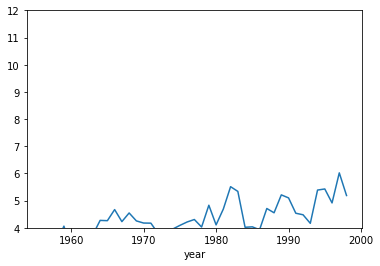

In [5]:
origin = '2030'
stations[origin].plot.line(ylim=(4,12))
oriSeries = stations[origin]

Then we have to calculate the difference between years so discontinuities in other series lose weight

In [6]:
ydiff ={}
for col in stations.columns[:]:
    ydiff[col] = stations[col].shift(-1)-stations[col]
yearDiff = pd.concat(ydiff.values(), axis=1).drop(1998)
yearDiff.head()

,1203,9069,9489,9269,9301,2030,2085,1017,9971,9390,9523,9371
year,,,,,,,,,,,,
1956,-0.58082,0.71187,0.45176,1.14686,0.83855,0.64986,-0.58232,0.3998,0.42315,0.65265,0.39094,0.46352
1957,0.98128,1.33746,1.42361,0.20822,0.74383,1.47491,1.33574,1.3843,1.00804,1.24800,1.10728,1.22272
1958,0.54998,-0.09563,0.38872,-0.65342,0.03659,0.61185,2.04666,0.7176,0.16905,0.22592,0.04055,0.55140
1959,0.01621,-0.26341,-0.50411,-0.26987,-0.14095,-0.81970,-0.82935,-0.6646,-0.58685,-0.21527,-0.58422,-0.58593
1960,-0.03555,0.13638,-0.00442,-0.16148,0.16299,0.18554,0.41630,0.3034,0.38831,-0.02364,0.03163,0.43891


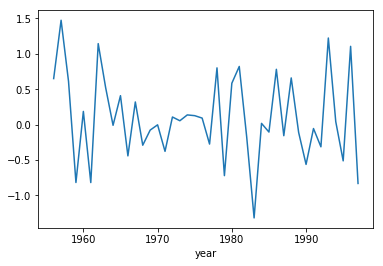

In [7]:
yearDiff[origin].plot.line()

At this point we can look for the stations with the best correlation in the year difference and took the first five:

In [8]:
correlations = yearDiff.corr(method='pearson')
bestSts = correlations[origin][correlations[origin] > 0.35].drop(origin).sort_values(ascending=False).head(5) \
            .to_frame(name='corrCoef') #drops origin index with corr = 1
bestSts['corrCoef2'] = bestSts['corrCoef']**2
bestSts

,corrCoef,corrCoef2
9390,0.744718,0.554605
1017,0.692712,0.479850
9371,0.684540,0.468595
9971,0.633948,0.401890
9523,0.619513,0.383796


Create a reference series with the five stations, weighted with R<sup>2</sup> 

In [9]:
refDict = {}
for index in bestSts.index:
    refDict[index] = yearDiff[index]*bestSts['corrCoef2'].loc[index]
refSeriesDiff = pd.concat(refDict.values(), axis=1).sum(axis=1)/bestSts['corrCoef2'].sum()

Taking the most recent data in the original station as valid we apply the annual difference

In [10]:
refSeries = oriSeries.copy()
for i,diff in enumerate(refSeriesDiff.sort_index(ascending=False).tolist()):
    refSeries.loc[1998-(i+1)] = refSeries.loc[1998-i]-diff
refSeries = refSeries.sort_index()

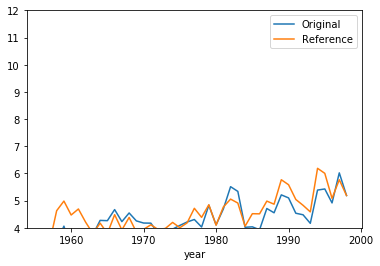

In [11]:
OriRefDF = pd.concat({'Reference':refSeries, 'Original':oriSeries}, axis=1)
OriRefDF.plot.line(ylim=(4,12))

Add a third column of the difference between reference and original series

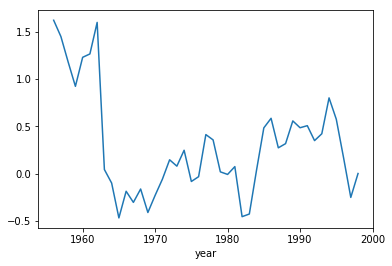

In [12]:
OriRefDF['diff']=OriRefDF['Reference'] - OriRefDF['Original']
OriRefDF['diff'].plot.line()

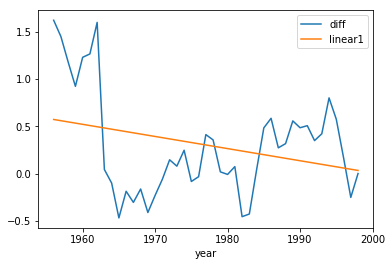

In [13]:
coef1, RSS1, _, _, _ = np.polyfit(OriRefDF.index,OriRefDF['diff'],1,full=True)
linear_reg1 = np.poly1d(coef1)
RSS1 = RSS1[0] #Maybe it would be better to plot the data without adding it to the DF
OriRefDF['linear1'] = np.NAN
for index in OriRefDF.index:
    OriRefDF['linear1'].loc[index] = linear_reg1(index)
OriRefDF[['diff','linear1']].plot.line()

We have to divide the series in two series so we can look for discontinuities

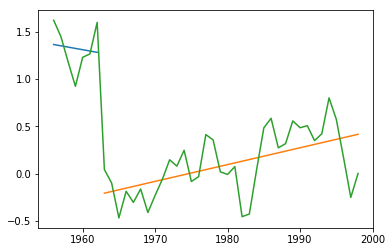

In [14]:
OriRefDF['RSS2'] = RSS1
for point in range(5,37):
    sub1 = OriRefDF['diff'].iloc[:point]
    sub2 = OriRefDF['diff'].iloc[point:]
    subcoef1, RSSs1,_,_,_ = np.polyfit(OriRefDF.index[:point],sub1,1,full=True)
    #sublinear_reg1 = np.poly1d(subcoef1)
    subcoef2, RSSs2,_,_,_ = np.polyfit(OriRefDF.index[point:],sub2,1,full=True)
    #sublinear_reg1 = np.poly1d(subcoef2)
    OriRefDF['RSS2'].iloc[point] = RSSs1[0] + RSSs2[0]
point = OriRefDF.index.get_loc(OriRefDF['RSS2'].idxmin())
RSS2 = OriRefDF['RSS2'].min()
subyear1 = OriRefDF.index[:point]
subyear2 = OriRefDF.index[point:]
subcoef1 = np.polyfit(subyear1,OriRefDF['diff'].iloc[:point],1)
subcoef2 = np.polyfit(subyear2,OriRefDF['diff'].iloc[point:],1)
sublinear_reg1 = np.poly1d(subcoef1)
sublinear_reg2 = np.poly1d(subcoef2)
plt.plot(subyear1,sublinear_reg1(subyear1),subyear2, sublinear_reg2(subyear2), OriRefDF.index, OriRefDF['diff'])

Now we know the year with minimum RSS2 so we ckeck in with an F-Test

In [15]:
solow(RSS1,RSS2,42)

True

Perform a Z-Test will stablish if it is a real discontinuity

In [16]:
sub1 = OriRefDF['diff'].iloc[:point]
sub2 = OriRefDF['diff'].iloc[point:]
Ztest(np.mean(sub1),np.mean(sub2),np.std(sub1),np.std(sub2),len(sub1),len(sub2))

True

In [17]:
scipy.stats.f.ppf(0.95,3,38)

2.8517413363298987

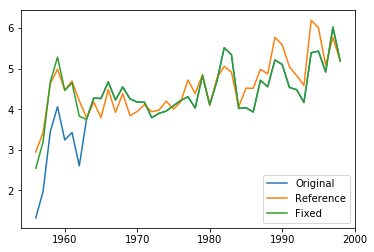

In [19]:
OriRefDF['Fixed']=OriRefDF['Original']
meanB = OriRefDF['diff'].iloc[:point].mean()
meanA = OriRefDF['diff'].iloc[point:].mean()
OriRefDF['Fixed'].iloc[:point] = OriRefDF['Fixed'].iloc[:point] + meanB - meanA
plt.plot(OriRefDF.index,OriRefDF['Original'],OriRefDF.index,OriRefDF['Reference'],OriRefDF.index,OriRefDF['Fixed'])
plt.legend(['Original','Reference','Fixed'])